In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import matplotlib.cm
import geopandas as gpd
import geodatasets
import imblearn
import random
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

In [30]:
households = pd.read_csv("households.csv", low_memory=False)
persons = pd.read_csv("persons.csv", low_memory=False)
trips = pd.read_csv("final_trips.csv", low_memory=False)
tours = pd.read_csv("final_tours.csv", low_memory=False)
zones = pd.read_csv("mgra15_based_input2022.csv")
pd.set_option('display.max_columns', None)

In [31]:
luz_map = gpd.read_file('LUZ')
taz_district = pd.read_csv('TAZ/taz_to_district.csv')
taz_luz = pd.read_csv('LUZ/xref_taz_luz.csv')
distances = pd.read_csv('LUZ/auto_AM_2022.csv')

In [32]:
households = households.rename(columns={'hhid': 'household_id'}).drop(['Unnamed: 0.4','Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0.1', 'Unnamed: 0'], axis=1)
persons = persons.rename(columns={'perid': 'person_id', 'hhid': 'household_id'}).drop(['Unnamed: 0.4','Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0.1', 'Unnamed: 0'], axis=1)
zones = zones.drop('Unnamed: 0', axis=1)

In [33]:
feature_df = pd.merge(tours, persons, how='left', on=['person_id', 'household_id'])
feature_df = pd.merge(feature_df, households[['household_id', 'taz', 'hinc']], how='left', on='household_id')
feature_df = pd.merge(trips[['trip_id', 'tour_id', 'purpose']], feature_df, how='left', on='tour_id')
feature_df = feature_df.drop(['tdd', 'tour_id_temp', 'destination_logsum', 'vehicle_occup_1', 'vehicle_occup_2', 'vehicle_occup_3.5', 'mode_choice_logsum'], axis=1)
feature_df = feature_df.rename(columns={'purpose': 'trip_purpose', 'start': 'start_time', 'end': 'end_time', 'pemploy': 'employment_status', 'pstudent': 'student_status', 'ptype': 'person_type', 'educ': 'education', 'weeks': 'weeks_worked', 'hours': 'hours_worked', 'rac1p': 'race', 'taz': 'household_taz', 'hinc': 'household_income'})
feature_df = feature_df.drop(['primary_purpose', 'household_serial_no', 'miltary', 'pnum', 'occen5', 'occsoc5', 'indcen', 'hisp', 'version', 'naics2_original_code', 'soc2'], axis=1)
feature_df.head(5)

,trip_id,tour_id,trip_purpose,person_id,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination,origin,household_id,start_time,end_time,duration,school_esc_outbound,school_esc_inbound,num_escortees,composition,is_external_tour,is_internal_tour,tour_mode,selected_vehicle,atwork_subtour_frequency,parent_tour_id,stop_frequency,age,sex,employment_status,student_status,person_type,education,grade,weeks_worked,hours_worked,race,household_taz,household_income
0,473,59,escort,1,escort,3,3,4,4,non_mandatory,1,5313.0,57.0,1,8.0,8.0,0.0,NaN,NaN,NaN,NaN,False,True,SHARED3,Van_6_Gas,NaN,NaN,0out_0in,34,2,1,3,1,13,0,1,40,1,46,78621
1,477,59,home,1,escort,3,3,4,4,non_mandatory,1,5313.0,57.0,1,8.0,8.0,0.0,NaN,NaN,NaN,NaN,False,True,SHARED3,Van_6_Gas,NaN,NaN,0out_0in,34,2,1,3,1,13,0,1,40,1,46,78621
2,505,63,eatout,2,eatout,1,1,1,1,joint,5,2574.0,57.0,1,30.0,31.0,1.0,NaN,NaN,NaN,children,False,True,WALK,NaN,NaN,NaN,0out_0in,16,2,3,1,6,0,5,0,0,1,46,78621
3,509,63,home,2,eatout,1,1,1,1,joint,5,2574.0,57.0,1,30.0,31.0,1.0,NaN,NaN,NaN,children,False,True,WALK,NaN,NaN,NaN,0out_0in,16,2,3,1,6,0,5,0,0,1,46,78621
4,521,65,othdiscr,1,othdiscr,1,1,3,4,joint,3,3481.0,57.0,1,15.0,17.0,2.0,NaN,NaN,NaN,mixed,False,True,WALK,NaN,NaN,NaN,0out_0in,34,2,1,3,1,13,0,1,40,1,46,78621


In [34]:
vehicles = feature_df['selected_vehicle'].str.split('_', expand=True)
feature_df['vehicle_type'] = vehicles[0]
feature_df['vehicle_age'] = vehicles[1]
feature_df['vehicle_propulsion'] = vehicles[2]
feature_df = feature_df.drop(['selected_vehicle'], axis=1)

In [35]:
stops = feature_df['stop_frequency'].str.replace(r'[^0-9]', '', regex=True).str.split('', expand=True).drop([0, 3], axis=1)
feature_df['out_stops'] = stops[1]
feature_df['in_stops'] = stops[2]
feature_df = feature_df.drop(['stop_frequency'], axis=1)

In [36]:
zones_dict = zones[['mgra', 'taz']].to_dict('list')
zones_dict_2 = dict(map(lambda i,j: (i,j), zones_dict['mgra'], zones_dict['taz']))
feature_df['destination'] = feature_df['destination'].map(zones_dict_2)
feature_df['origin'] = feature_df['origin'].map(zones_dict_2)

In [37]:
trip_purpose = {'home': 1,
               'shopping': 2,
               'othmaint': 3,
               'work': 4,
               'othdiscr': 5,
               'eatout': 6,
               'escort': 7,
               'atwork': 8,
               'social': 9,
               'school': 10,
               'univ': 11}
feature_df['trip_purpose'] = feature_df['trip_purpose'].map(trip_purpose)

In [38]:
tour_category = {'non_mandatory': 1,
                'mandatory': 2,
                'joint': 3,
                'atwork': 4}
feature_df['tour_category'] = feature_df['tour_category'].map(tour_category)

In [39]:
tour_type = {'work': 1,
             'othdiscr': 2,
             'escort': 3,
             'othmaint': 4,
             'shopping': 5,
             'school': 6,
             'eatout': 7,
             'eat': 8,
             'social': 9,
             'business': 10,
             'maint': 11}
feature_df['tour_type'] = feature_df['tour_type'].map(tour_type)

In [40]:
feature_df['start_time'] = feature_df['start_time'] / 2

In [41]:
feature_df['end_time'] = feature_df['end_time'] / 2

In [42]:
feature_df['duration'] = feature_df['duration'] / 2

In [43]:
vehicle_type = {'Car': 1,
               'SUV': 2,
               'Pickup': 3,
               'Van': 4,
               'Motorcycle': 5,
               'non': np.nan}
feature_df['vehicle_type'] = feature_df['vehicle_type'].map(vehicle_type)

In [44]:
vehicle_propulsion = {'Gas': 1,
                     'Hybrid': 2,
                     'veh': np.nan,
                     'Diesel': 3,
                     'PEV': 4,
                     'BEV': 5}
feature_df['vehicle_propulsion'] = feature_df['vehicle_propulsion'].map(vehicle_propulsion)

In [45]:
true_false = {True: 1,
              False: 2}
feature_df['is_external_tour'] = feature_df['is_external_tour'].map(true_false)
feature_df['is_internal_tour'] = feature_df['is_internal_tour'].map(true_false)

In [48]:
features = feature_df

In [49]:
taz_district = taz_district.rename(columns={'TAZ': 'household_taz'})
features = pd.merge(features, taz_district, how='left', on=['household_taz'])
luz_map = luz_map.rename(columns={'LUZ': 'household_luz'})
luz_dict = taz_luz[['taz', 'luz']].to_dict('list')
luz_dict_2 = dict(map(lambda i,j: (i,j), luz_dict['taz'], luz_dict['luz']))
features = features.rename(columns={'household_taz': 'household_luz'})
features['household_luz'] = features['household_luz'].map(luz_dict_2)
features['destination'] = features['destination'].map(luz_dict_2)
features['origin'] = features['origin'].map(luz_dict_2)

features = pd.merge(features, luz_map, how='left', on=['household_luz'])
features = features[features['district'].isin([1, 2, 5, 6])]
features = features.dropna(subset=['origin', 'destination'])
features.head(5)

,trip_id,tour_id,trip_purpose,person_id,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination,origin,household_id,start_time,end_time,duration,school_esc_outbound,school_esc_inbound,num_escortees,composition,is_external_tour,is_internal_tour,tour_mode,atwork_subtour_frequency,parent_tour_id,age,sex,employment_status,student_status,person_type,education,grade,weeks_worked,hours_worked,race,household_luz,household_income,vehicle_type,vehicle_age,vehicle_propulsion,out_stops,in_stops,district,Shape_Leng,Shape_Area,geometry
0,473,59,7,1,3,3,3,4,4,1,1,162.0,33.0,1,4.0,4.0,0.0,NaN,NaN,NaN,NaN,2.0,1.0,SHARED3,NaN,NaN,34,2,1,3,1,13,0,1,40,1,161,78621,4.0,6,1.0,0,0,6,60857.839594,7.532031e+07,"POLYGON ((6211740.390 2021393.042, 6212202.325..."
1,477,59,1,1,3,3,3,4,4,1,1,162.0,33.0,1,4.0,4.0,0.0,NaN,NaN,NaN,NaN,2.0,1.0,SHARED3,NaN,NaN,34,2,1,3,1,13,0,1,40,1,161,78621,4.0,6,1.0,0,0,6,60857.839594,7.532031e+07,"POLYGON ((6211740.390 2021393.042, 6212202.325..."
2,505,63,6,2,7,1,1,1,1,3,5,161.0,33.0,1,15.0,15.5,0.5,NaN,NaN,NaN,children,2.0,1.0,WALK,NaN,NaN,16,2,3,1,6,0,5,0,0,1,161,78621,NaN,NaN,NaN,0,0,6,60857.839594,7.532031e+07,"POLYGON ((6211740.390 2021393.042, 6212202.325..."
3,509,63,1,2,7,1,1,1,1,3,5,161.0,33.0,1,15.0,15.5,0.5,NaN,NaN,NaN,children,2.0,1.0,WALK,NaN,NaN,16,2,3,1,6,0,5,0,0,1,161,78621,NaN,NaN,NaN,0,0,6,60857.839594,7.532031e+07,"POLYGON ((6211740.390 2021393.042, 6212202.325..."
4,521,65,5,1,2,1,1,3,4,3,3,161.0,33.0,1,7.5,8.5,1.0,NaN,NaN,NaN,mixed,2.0,1.0,WALK,NaN,NaN,34,2,1,3,1,13,0,1,40,1,161,78621,NaN,NaN,NaN,0,0,6,60857.839594,7.532031e+07,"POLYGON ((6211740.390 2021393.042, 6212202.325..."


In [50]:
X = features[['trip_purpose',
               'tour_type',
               'tour_category',
               'origin',
               'number_of_participants',
               'start_time',
               'age',
               'employment_status',
               'student_status',
               'education',
               'household_income']]
y = features['destination']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [51]:
num_samples = int(np.median(y_train.value_counts().tolist())) #desired number of samples

#oversample if lower than num_samples
sampling_strategy = {label: num_samples if count < num_samples else count for label, count in Counter(y_train).items()}

smote = SMOTE(k_neighbors = 4, sampling_strategy = sampling_strategy)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(len(X_resampled))

#use X_resampled and y_resampled as training data for model

4379027


In [52]:
st = time.time()
model = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0, max_depth=45, criterion='entropy')
model.fit(X_resampled, y_resampled)
y_test_pred = model.predict(X_test)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 84.81306028366089 seconds


In [53]:
report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=np.nan)
report_df = pd.DataFrame(report).transpose()[-3:]
report_df

,precision,recall,f1-score,support
accuracy,0.864715,0.864715,0.864715,0.864715
macro avg,0.812947,0.845451,0.826664,983920.000000
weighted avg,0.865029,0.864715,0.864803,983920.000000


In [54]:
results = pd.DataFrame(np.transpose(np.unique(y_test_pred, return_counts=True)), columns=['destination', 'count'])
results.head(10)

,destination,count
0,1.0,5071.0
1,2.0,7702.0
2,3.0,14893.0
3,4.0,16029.0
4,5.0,27268.0
5,6.0,8584.0
6,7.0,11103.0
7,8.0,12576.0
8,9.0,11978.0
9,10.0,16886.0


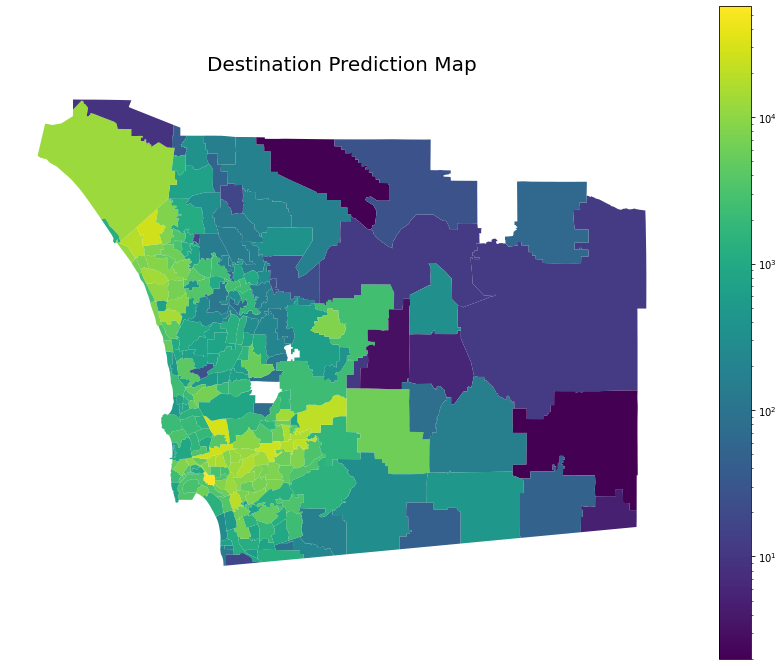

In [55]:
merged_res = luz_map.merge(results, how='left', left_on='household_luz', right_on='destination')

# Plot choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plotting the count as the choropleth
merged_res.plot(column='count', ax=ax, legend=True, cmap='viridis', linewidth=0.25, norm=matplotlib.colors.LogNorm(vmin=merged_res['count'].min(), vmax=merged_res['count'].max()))

# Customize the plot
ax.set_title("Destination Prediction Map", fontsize=20)
ax.set_axis_off()
plt.show()

In [56]:
distances = distances.rename(columns={'orig': 'origin'})
distances = distances.rename(columns={'dest': 'destination'})
distances.head(10)

,origin,destination,time,distance,tollcost,totalCost
0,1,1,2.258438,0.625757,0.0,0.120145
1,1,2,8.029609,2.398701,0.0,0.460551
2,1,3,8.928603,2.177131,0.0,0.418009
3,1,4,13.188757,4.410942,0.0,0.846901
4,1,5,12.220571,4.316603,0.0,0.828788
5,1,6,13.893533,5.992565,0.0,1.150572
6,1,7,17.602363,6.485136,0.0,1.245146
7,1,8,19.102962,7.165548,0.0,1.375785
8,1,9,16.378442,8.077410,0.0,1.550863
9,1,10,19.312948,9.950424,0.0,1.910481


In [57]:
pred_distance_df = pd.DataFrame(y_test_pred, columns=['destination']).reset_index().drop(columns=['index'])
pred_distance_df[['origin', 'employment_status']] = pd.DataFrame(X_test[['origin', 'employment_status']]).reset_index()[['origin', 'employment_status']]
pred_distance_df.head(10)

,destination,origin,employment_status
0,16.0,33.0,3
1,119.0,33.0,3
2,104.0,67.0,1
3,121.0,23.0,3
4,207.0,33.0,3
5,91.0,39.0,1
6,110.0,42.0,1
7,3.0,99.0,2
8,28.0,85.0,1
9,239.0,110.0,1


In [58]:
real_distance_df = pd.DataFrame(y_test, columns=['destination']).reset_index().drop(columns=['index'])
real_distance_df[['origin', 'employment_status']] = pd.DataFrame(X_test[['origin', 'employment_status']]).reset_index()[['origin', 'employment_status']]
real_distance_df.head(10)

,destination,origin,employment_status
0,51.0,33.0,3
1,119.0,33.0,3
2,104.0,67.0,1
3,121.0,23.0,3
4,207.0,33.0,3
5,91.0,39.0,1
6,110.0,42.0,1
7,3.0,99.0,2
8,28.0,85.0,1
9,239.0,110.0,1


In [59]:
pred_distance_df = pd.merge(pred_distance_df, distances[['origin', 'destination', 'distance']], on=['origin', 'destination'], how='left')
pred_distance_df['Data Source'] = 'Our Model'
#pred_distance_df = pred_distance_df[['destination', 'origin', 'distance', 'Data Source']]
pred_distance_df.head(10)

,destination,origin,employment_status,distance,Data Source
0,16.0,33.0,3,18.129387,Our Model
1,119.0,33.0,3,18.516792,Our Model
2,104.0,67.0,1,20.606109,Our Model
3,121.0,23.0,3,18.146315,Our Model
4,207.0,33.0,3,32.842536,Our Model
5,91.0,39.0,1,26.352036,Our Model
6,110.0,42.0,1,22.156462,Our Model
7,3.0,99.0,2,10.661257,Our Model
8,28.0,85.0,1,16.603696,Our Model
9,239.0,110.0,1,8.348599,Our Model


In [60]:
real_distance_df = pd.merge(real_distance_df, distances[['origin', 'destination', 'distance']], on=['origin', 'destination'], how='left')
real_distance_df['Data Source'] = 'SANDAG Synthetic'
real_distance_df.head(10)

,destination,origin,employment_status,distance,Data Source
0,51.0,33.0,3,17.598769,SANDAG Synthetic
1,119.0,33.0,3,18.516792,SANDAG Synthetic
2,104.0,67.0,1,20.606109,SANDAG Synthetic
3,121.0,23.0,3,18.146315,SANDAG Synthetic
4,207.0,33.0,3,32.842536,SANDAG Synthetic
5,91.0,39.0,1,26.352036,SANDAG Synthetic
6,110.0,42.0,1,22.156462,SANDAG Synthetic
7,3.0,99.0,2,10.661257,SANDAG Synthetic
8,28.0,85.0,1,16.603696,SANDAG Synthetic
9,239.0,110.0,1,8.348599,SANDAG Synthetic


In [65]:
merged = pd.concat([pred_distance_df, real_distance_df], axis=0)
merged_plot = merged.rename(columns={'employment_status': 'Employment Status'})
merged_plot.head(10)

,destination,origin,Employment Status,distance,Data Source
0,16.0,33.0,3,18.129387,Our Model
1,119.0,33.0,3,18.516792,Our Model
2,104.0,67.0,1,20.606109,Our Model
3,121.0,23.0,3,18.146315,Our Model
4,207.0,33.0,3,32.842536,Our Model
5,91.0,39.0,1,26.352036,Our Model
6,110.0,42.0,1,22.156462,Our Model
7,3.0,99.0,2,10.661257,Our Model
8,28.0,85.0,1,16.603696,Our Model
9,239.0,110.0,1,8.348599,Our Model


In [66]:
merged_sample = merged_plot.sample(10000, replace=False)
merged_sample.head(10)

,destination,origin,Employment Status,distance,Data Source
32216,156.0,25.0,4,34.471337,Our Model
959509,244.0,162.0,1,27.175854,Our Model
419611,185.0,38.0,3,36.270015,SANDAG Synthetic
972384,169.0,151.0,4,28.584270,SANDAG Synthetic
5584,160.0,76.0,2,39.042656,Our Model
720548,63.0,16.0,1,16.903906,Our Model
658416,53.0,161.0,1,26.570382,Our Model
679122,106.0,49.0,4,27.157019,SANDAG Synthetic
101595,94.0,4.0,1,7.354511,Our Model
364812,16.0,110.0,1,3.249227,Our Model


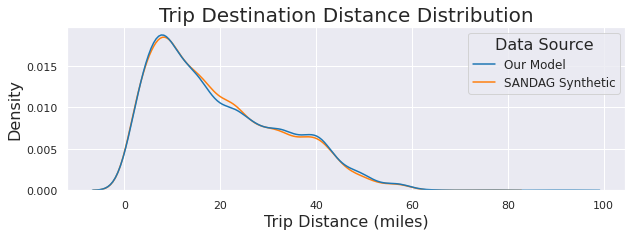

In [67]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10, 3))
ax = sns.kdeplot(ax=ax, data=merged_sample, x='distance', alpha=1, hue='Data Source', linewidth=1.5, palette='tab10')
plt.setp(ax.get_legend().get_title(), fontsize='16');
plt.setp(ax.get_legend().get_texts(), fontsize='12');
ax.set_title("Trip Destination Distance Distribution", fontsize=20)
ax.set_xlabel("Trip Distance (miles)",fontsize=16);
ax.set_ylabel("Density",fontsize=16);

In [64]:
# Bootstrap
n_iterations = 5000
bootstrap_stats = []
observed_statistic = stats.ks_2samp(pred_distance_df['distance'], real_distance_df['distance']).statistic

for _ in range(n_iterations):
    sample1 = pred_distance_df['distance'].sample(10000, replace=True)
    sample2 = real_distance_df['distance'].sample(10000, replace=True)
    bootstrap_stat = stats.ks_2samp(sample1, sample2).statistic
    bootstrap_stats.append(bootstrap_stat)

# Compute the p-value
p_value = np.sum(np.abs(bootstrap_stats) >= np.abs(observed_statistic)) / n_iterations

print("Observed Statistic:", observed_statistic)
print("P-Value:", p_value)

# Decision
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Observed Statistic: 0.0006128547036344245
P-Value: 1.0
Fail to reject the null hypothesis
